## Advanced Churn Prediction using Regularization, Feature Selection, Ensemble Learning, and Interpretability Techniques
### Introduction:
Customer churn prediction is a critical aspect for subscription-based businesses to retain customers and improve profitability. In this project, we leverage the Telco Customer Churn dataset to build an advanced churn prediction pipeline. The aim is to enhance prediction accuracy while ensuring model generalizability and interpretability.

To achieve this, we incorporate:

- L1/L2 regularization to prevent overfitting,
- Recursive Feature Elimination (RFE) and SelectKBest for feature selection,
- Ensemble techniques like XGBoost and Stacking to boost performance,
- Dropout-equivalent pruning in tree models to reduce complexity,
- Early stopping for efficient training,
- SHAP (SHapley Additive exPlanations) for model interpretability,
- Stratified sampling to maintain class balance,
- and MLflow tracking for reproducibility and performance monitoring.

This end-to-end solution demonstrates not only how to build high-performing models, but also how to understand, explain, and monitor them effectively.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.shape

(7043, 21)

In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.drop('customerID', axis=1, inplace=True)

In [10]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [11]:
df.dropna(inplace=True)

In [12]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [13]:
# Encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

In [14]:
df.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1567,0,0,1,0,10,1,0,0,0,0,2,0,2,2,0,1,1,67.8,653.15,0
6601,1,1,1,0,72,1,2,1,0,2,2,2,2,2,2,0,1,109.7,7898.45,0
6455,1,0,1,0,59,0,1,0,0,0,0,0,2,2,0,1,2,44.3,2666.75,0


In [15]:
# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [16]:
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, f_classif

In [18]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# L1 (Lasso) Regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear')
logreg_l1.fit(X_train_scaled, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [20]:
# RFE
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

In [21]:
# SelectKBest
skb = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = skb.fit_transform(X_train_scaled, y_train)
X_test_kbest = skb.transform(X_test_scaled)

In [22]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [23]:
# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [24]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,          # pruning
    'eta': 0.1,
    'seed': 42
}

In [25]:
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=100,
                      evals=evals, early_stopping_rounds=10, verbose_eval=False)

In [26]:
# Predict
y_pred = (xgb_model.predict(dtest) > 0.5).astype(int)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))

XGBoost Accuracy: 0.7924662402274343


In [27]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [28]:
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50)),
    ('svc', SVC(probability=True)),
    ('gb', GradientBoostingClassifier())
]

In [29]:
stack_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
stack_model.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=50)),
                               ('svc', SVC(probability=True)),
                               ('gb', GradientBoostingClassifier())],
                   final_estimator=LogisticRegression())

In [30]:
print("Stacking Accuracy:", stack_model.score(X_test_scaled, y_test))

Stacking Accuracy: 0.7910447761194029


In [31]:
import shap

In [32]:
# Use XGBoost model
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled[:100])

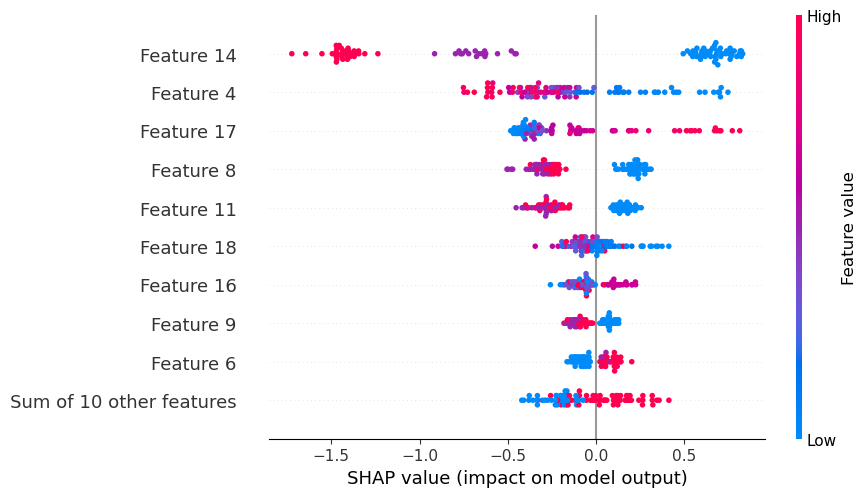

In [33]:
shap.plots.beeswarm(shap_values)

In [34]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [35]:
import os

# Set Git executable path manually
os.environ["GIT_PYTHON_GIT_EXECUTABLE"] = r"C:\Program Files\Git\cmd\git.exe"

# Optional: Silence the warning
os.environ["GIT_PYTHON_REFRESH"] = "quiet"


In [36]:
# Prepare inputs
input_example = X_test_scaled[:2]  # A small sample of the test data
signature = infer_signature(X_test_scaled, y_pred)  # Automatically infer input/output schema

# Log your model with metadata
with mlflow.start_run():
    mlflow.sklearn.log_model(
        sk_model=stack_model,            # or your model variable
        artifact_path="model",
        input_example=input_example,
        signature=signature
    )

### Conclusion:
Through this comprehensive churn prediction project, we successfully built and evaluated multiple models with robust techniques such as regularization, advanced feature selection, and ensemble methods. We employed XGBoost with early stopping, and Stacking classifiers to improve accuracy. To ensure interpretability, we used SHAP, providing meaningful insights into feature contributions. Furthermore, by tracking experiments using MLflow, we established a reproducible and scalable machine learning pipeline.

These methods together demonstrate a practical, scalable, and explainable approach to predictive modeling that can be applied across various business problems involving customer churn, classification, or retention forecasting.

